# Tiny Shakespeare RNN (Inspired by Karpathy)

In this notebook:
1. Load the [karpathy/tiny_shakespeare](https://huggingface.co/datasets/karpathy/tiny_shakespeare) dataset.
2. Build a simple character-level RNN (PyTorch) to predict next characters.
3. Train for multiple epochs, showing generated text after 10, 20, 30 epochs, etc.
4. Display next-token probability distributions.
5. Display an **activation map** for the RNN (hidden states) to see what’s lighting up.

For reference, see [Andrej Karpathy’s RNN effectiveness blog post](https://karpathy.github.io/2015/05/21/rnn-effectiveness/).

In [1]:
# Install dependencies if needed:
# !pip install datasets torch

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 42
torch.manual_seed(seed)

## 1. Load the Tiny Shakespeare Data
We get a single text string from the dataset, then build a char-level vocabulary.

In [2]:
tiny_data = load_dataset('karpathy/tiny_shakespeare', )
train_texts = tiny_data['train']['text']  # list of strings

# Typically there's only 1 record with entire text.
all_text = " ".join(train_texts)
print(f"Dataset length in chars: {len(all_text)}")

# Build vocab
chars = sorted(list(set(all_text)))
vocab_size = len(chars)
print(f"Vocabulary size: {vocab_size}")

# char to int, int to char
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for ch,i in stoi.items() }

Dataset length in chars: 1003854
Vocabulary size: 65


We’ll define a function to encode sequences of characters to integer IDs and decode back to characters. Then we’ll create train splits. For simplicity, we’ll just keep the entire text as a single sequence, though more sophisticated approaches might do chunking.

In [3]:
def encode_text(text):
    return [stoi[ch] for ch in text]

def decode_ids(ids):
    return ''.join(itos[i] for i in ids)

data_ids = torch.tensor(encode_text(all_text), dtype=torch.long)
print("Encoded data shape:", data_ids.shape)

# Let's do 90% for train, 10% for val
n = int(0.9*len(data_ids))
train_ids = data_ids[:n]
val_ids   = data_ids[n:]
print("train, val shapes:", train_ids.shape, val_ids.shape)

Encoded data shape: torch.Size([1003854])
train, val shapes: torch.Size([903468]) torch.Size([100386])


## 2. Create a Char-Level RNN Model
We’ll do a small 1-layer LSTM or basic RNN that outputs logits over `vocab_size` for each step. (You can also do a custom naive RNN if you prefer following Karpathy’s minimal example, but here we can do PyTorch’s built-in so we can easily show the hidden states, etc.)

In [4]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_size=128):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_size, num_layers=1, batch_first=True)
        self.fc  = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        # x: (batch, seq)
        emb = self.embed(x)  # (batch, seq, embed_dim)
        if hidden is None:
            out, hidden = self.rnn(emb)
        else:
            out, hidden = self.rnn(emb, hidden)

        logits = self.fc(out)  # (batch, seq, vocab_size)
        return logits, hidden

    def generate(self, start_char, max_new_tokens=100):
        # quick sampling method
        self.eval()
        with torch.no_grad():
            hidden = None
            x = torch.tensor([[stoi[start_char]]], dtype=torch.long, device=device)
            out_str = [start_char]
            for _ in range(max_new_tokens):
                logits, hidden = self.forward(x, hidden=hidden)
                # take the last time step
                last_logits = logits[:,-1,:]  # shape (1, vocab_size)
                probs = F.softmax(last_logits, dim=-1)
                # sample
                ix = torch.multinomial(probs, num_samples=1)
                x = ix
                ch = itos[ix.item()]
                out_str.append(ch)
            return ''.join(out_str)

    def next_token_probs(self, context):
        # Returns the next-token prob distribution for a given context string.
        self.eval()
        with torch.no_grad():
            hidden = None
            x = torch.tensor([encode_text(context)], dtype=torch.long, device=device)
            logits, hidden = self.forward(x)
            last_logits = logits[0,-1,:]  # shape (vocab_size,)
            probs = F.softmax(last_logits, dim=0)
        return probs.cpu().numpy()

    def get_activations(self, context):
        # We'll fetch hidden state after feeding context
        self.eval()
        with torch.no_grad():
            x = torch.tensor([encode_text(context)], dtype=torch.long, device=device)
            emb = self.embed(x)
            out, hidden = self.rnn(emb)
            # out shape: (1, seq_len, hidden_size)
            # hidden: tuple((1, batch, hidden_size), (1, batch, hidden_size)) for LSTM
        return out.squeeze(0).cpu().numpy()  # shape: (seq_len, hidden_size)

### 2.1 Prepare a batch loader function
We’ll define a simple function that, given a chunk of text, returns `(X, Y)` where `X` is input chars and `Y` is next chars.

In [5]:
def get_batch(data_ids, seq_len=128, batch_size=32):
    # Random starting indices
    ix = np.random.randint(0, len(data_ids) - seq_len - 1, (batch_size,))
    Xb = []
    Yb = []
    for i in ix:
        chunk = data_ids[i:i+seq_len]
        target = data_ids[i+1:i+seq_len+1]
        Xb.append(chunk)
        Yb.append(target)
    # Use torch.stack to combine the tensors
    Xb = torch.stack(Xb)
    Yb = torch.stack(Yb)
    return Xb, Yb


## 3. Training the RNN
We’ll train for 3000 epochs total, sampling text after training for 50 epochs to show progress. The blog post indicates small RNNs can generate surprisingly coherent text even after a short time.

We also keep the next-token probability map and an activation map for a sample context.

In [6]:
model = CharRNN(vocab_size=vocab_size, embed_dim=64, hidden_size=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

def compute_loss_fn(logits, targets):
    B,S,V = logits.shape
    logits_flat = logits.view(B*S, V)
    targets_flat = targets.view(B*S)
    return F.cross_entropy(logits_flat, targets_flat)

max_epochs = 3000
seq_len = 128
batch_size = 32
losses = []

for epoch in range(0, max_epochs+1):
    model.train()
    Xb, Yb = get_batch(train_ids, seq_len=seq_len, batch_size=batch_size)
    Xb, Yb = Xb.to(device), Yb.to(device)
    optimizer.zero_grad()
    logits, _ = model(Xb)
    loss = compute_loss_fn(logits, Yb)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch%50==0:
        print(f"Epoch {epoch}, loss: {loss.item():.4f}")
    
    # sample text at epochs 50, 100, 150, 200, 250, 300...
    if epoch in range(0, 3001, 50):
        model.eval()
        sample = model.generate(start_char='T', max_new_tokens=200)
        print(f"\n=== Sample after epoch {epoch} ===\n{sample}\n===========================\n")

Epoch 0, loss: 4.1908

=== Sample after epoch 0 ===
T!'iEU;kTgUglOvNvkinqP;gRRCzryBWc;UcrRtoYz-JcZ;nbL?uZc TrqoS-Kr sS!v,xszIW?F!Cmz,Zp-&
pHugDZok.z-Yf$cbzL$rDaB!
ApEgY-S lOQ
 wHYc?!JTR$pXRT$:qt..e:lFqOFw EHlpXNAHARJUVTmSgDN ',XJd,M!hYyrXRM;oJIlv.
.byhy

Epoch 50, loss: 2.4465

=== Sample after epoch 50 ===
T:hen touvlh,
Wonorith I fouis kouso nnvo he'n son shofrshen th met aret altour y yor axLl, of fig orerl

ee too itisisg waplshathe sove, pnoc, be tof homr itn
;e, toe.
A h.
EReN thedic fithe for imaus

Epoch 100, loss: 2.2058

=== Sample after epoch 100 ===
Tould be crecke sont stell tuntat breccand nofthak thy book.
Foun pont mudio fonce shet sy loost ss of thish vest thee, to-wed yur,; and, forith as seen cumne I it all owull dethe' file.er kev
Nome.
Th

Epoch 150, loss: 2.0445

=== Sample after epoch 150 ===
Th ring thiph the shell chat kinent, and cakfingh?
Pinchabe the have.
Shy linve themsand, widing that thin I ham hes kinds
OUH Nf rues attion a trirveat theum gekie beef, be

Quite impressive, at first we have just random characters, but after a few epochs we see that the networks have learned to create bags of characters. Then it really starts to generate coherent words even if the bag of words are not very good. And we see some patterns with capital letters and punctuation. It definitely gets the idea of the character speaking. And it looks to master the punctuation at the end, and even we get some kind of good couple of words in a row.

### Plot Training Loss

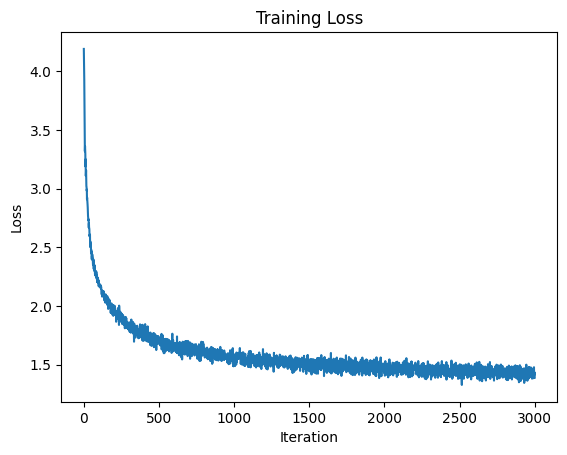

In [7]:
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

## 4. Next-Token Probability Map


We'll pick a small context (e.g. `'Thou art'`) and see the predicted distribution for the next character.

### 1) Function: `top5_probs_across_phrase`

This function:
- Iterates over a given phrase **character by character**,
- Feeds the substring to the model,
- Captures the softmax distribution for the *next* character,
- Extracts the top-5 indices and probabilities for each position,
- Returns a matrix of probabilities and the corresponding top-5 characters.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display


def top5_probs_across_phrase(model, phrase, stoi, itos):
    """
    For each character in 'phrase', compute the RNN model's next-token probability
    distribution, pick top-5 tokens, store them, and return a matrix for heatmap, etc.

    model: A char-level RNN (PyTorch) with a forward(...) that returns (logits, hidden).
    phrase: The input string we feed character by character.
    stoi: dict mapping chars -> integer IDs.
    itos: dict mapping integer IDs -> chars.

    Returns:
      top5_probs: shape (T, 5), top-5 probabilities for each time step
      top5_chars: list of lists of top-5 characters per time step
    """
    model.eval()
    distributions = []
    top5_indices_list = []

    hidden = None
    with torch.no_grad():
        for t in range(len(phrase)):
            # feed context up to (t+1)th character
            context_sub = phrase[:t+1]
            x = torch.tensor([[stoi[ch] for ch in context_sub]], dtype=torch.long, device=device)
            logits, hidden = model(x, hidden=hidden)

            # take the last output => next char distribution
            last_logits = logits[0, -1, :]  # shape (vocab_size,)
            probs = torch.softmax(last_logits, dim=-1).cpu().numpy()

            distributions.append(probs)

            # top-5 indices
            idx_sorted = np.argsort(-probs)
            top5_idx = idx_sorted[:5]
            top5_indices_list.append(top5_idx)

    # Convert to arrays
    distributions = np.array(distributions)  # shape (T, vocab_size)
    T = len(phrase)
    top5_probs = np.zeros((T, 5))
    top5_chars = []

    for i in range(T):
        t5i = top5_indices_list[i]
        t5p = distributions[i][t5i]
        top5_probs[i,:] = t5p
        t5c = [itos[j] for j in t5i]
        top5_chars.append(t5c)

    return top5_probs, top5_chars


### 2) Using `top5_probs_across_phrase` + Heatmap

- We generate top-5 predictions for each step of a phrase.
- We print them in text form.
- We create a heatmap to visualize how probabilities evolve over each time step.


After reading 'T' (last char 'T'):
   'h' -> 0.437
   'o' -> 0.184
   'I' -> 0.073
   'H' -> 0.055
   'E' -> 0.049

After reading 'Th' (last char 'h'):
   'y' -> 0.262
   'e' -> 0.221
   'i' -> 0.209
   'o' -> 0.174
   'u' -> 0.078

After reading 'The' (last char 'e'):
   'n' -> 0.414
   'r' -> 0.232
   's' -> 0.181
   ' ' -> 0.100
   'R' -> 0.022

After reading 'The ' (last char ' '):
   'r' -> 0.232
   'C' -> 0.091
   'm' -> 0.060
   's' -> 0.060
   't' -> 0.048

After reading 'The o' (last char 'o'):
   'r' -> 0.194
   't' -> 0.183
   'n' -> 0.162
   'w' -> 0.137
   'f' -> 0.093

After reading 'The or' (last char 'r'):
   ' ' -> 0.865
   'd' -> 0.021
   '
' -> 0.019
   'e' -> 0.019
   'i' -> 0.011

After reading 'The orc' (last char 'c'):
   'e' -> 0.769
   'h' -> 0.123
   'o' -> 0.078
   'u' -> 0.020
   'i' -> 0.004

After reading 'The orch' (last char 'h'):
   'e' -> 0.382
   'u' -> 0.232
   'a' -> 0.196
   'i' -> 0.116
   'o' -> 0.061

After reading 'The orcha' (last char 'a'):


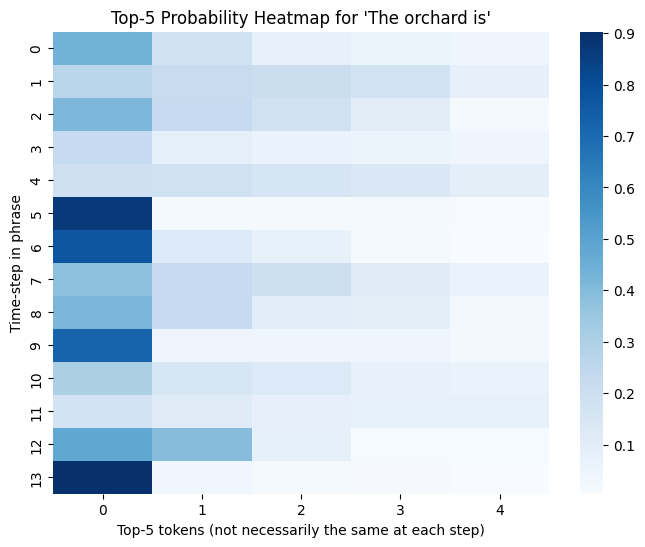

In [9]:
# Example usage
context_phrase = "The orchard is"

top5_matrix, top5_chs = top5_probs_across_phrase(model, context_phrase, stoi, itos)

# 1) Print top-5 tokens for each step
for i, ch in enumerate(context_phrase):
    print(f"\nAfter reading '{context_phrase[:i+1]}' (last char '{ch}'):")
    t5c = top5_chs[i]
    t5p = top5_matrix[i]
    # sort them by descending probability for readability
    idx_desc = np.argsort(-t5p)
    for rank in range(5):
        char_ = t5c[idx_desc[rank]]
        prob_ = t5p[idx_desc[rank]]
        print(f"   '{char_}' -> {prob_:.3f}")

# 2) Heatmap of top-5 probabilities (T x 5)
plt.figure(figsize=(8,6))
sns.heatmap(top5_matrix, annot=False, cmap='Blues')
plt.title(f"Top-5 Probability Heatmap for '{context_phrase}'")
plt.xlabel("Top-5 tokens (not necessarily the same at each step)") 
plt.ylabel("Time-step in phrase")
plt.show()

We see that sometimes the network is really sure about the next character, and sometimes it is not. Maybe we should look at clear characters to look for potential overfitting. 

### 3) Color Functions for Activation and Probability

The next functions color a value from [-1,1] in a blue->white->green scale, and from [0,1] in white->red scale, for probability.

In [10]:
def color_val_for_activation(a_value):
    """
    Map activation in [-1, 1] to a color gradient:
    blue at -1, white at 0, green at 1.
    R=0..0, G=0..255, B=255..0
    """
    av = max(-1.0, min(1.0, a_value))
    scale = (av + 1.0) * 0.5  # 0 => -1, 1 => +1
    g = int(scale * 255)
    b = int((1.0 - scale) * 255)
    return f"rgb(0,{g},{b})"

def color_val_for_prob(p):
    """
    Map probability in [0,1] to a color from white(0) to red(1).
    We'll do purely red: white => p=0 => rgb(255,255,255)
                        red => p=1 => rgb(255,0,0)
    """
    p_clamped = max(0.0, min(1.0, p))
    r = 255
    g = int(255 - 255*p_clamped)
    b = int(255 - 255*p_clamped)
    return f"rgb({r},{g},{b})"

def visualize_firing_and_guesses(
    text,
    hidden_vals,     # shape (T, hidden_size)
    top5_ix,         # shape (T, 5)
    top5_probs,      # shape (T, 5)
    encoded_input,   # shape (T,)
    neuron_idx = 0,
    itos = None
):
    """
    text: original input string
    hidden_vals: (T, hidden_size), hidden states for each time step
    top5_ix: (T, 5)
    top5_probs: (T, 5)
    neuron_idx: which dimension of hidden state to visualize
    itos: index->char mapping
    """
    T = len(text)
    html = []
    html.append("<div style='font-family:monospace;'>")
    html.append("<table>")

    # Row 1: input characters colored by hidden state dimension
    html.append("<tr>")
    for t in range(T):
        char_ = text[t]
        a_val = hidden_vals[t, neuron_idx]  # e.g. LSTM hidden dimension
        ccol = color_val_for_activation(a_val)
        html.append(f"<td style='background-color:{ccol}; padding:4px;'>{char_}</td>")
    html.append("</tr>")

    # Row 2: top-5 guesses
    html.append("<tr>")
    for t in range(T):
        guesses_ix = top5_ix[t]
        guesses_pb = top5_probs[t]
        cell_lines = []
        for i in range(5):
            gix = guesses_ix[i]
            p_ = guesses_pb[i]
            ch_ = itos[gix] if itos else f"{gix}"
            ccol = color_val_for_prob(p_)
            cell_lines.append(f"<span style='background-color:{ccol}'>{ch_} {p_:.2f}</span>")
        cell_html = "<br/>".join(cell_lines)
        html.append(f"<td style='vertical-align:top; padding:4px;'>{cell_html}</td>")
    html.append("</tr>")

    html.append("</table>")
    html.append("</div>")
    return "".join(html)

# We'll define a hypothetical function that obtains hidden states + top5
# for each step of a phrase. It's similar to 'top5_probs_across_phrase', but also
# we store hidden states. Let's call it `get_firing_and_top5(...)`.

def get_firing_and_top5(model, text, stoi, itos):
    """
    Returns:
      hidden_vals: shape (T, hidden_size)
      top5_ix: (T,5)
      top5_probs: (T,5)
    """
    model.eval()
    hidden_vals = []
    top5_ix = []
    top5_pb = []
    hidden = None

    with torch.no_grad():
        for t in range(len(text)):
            context_sub = text[:t+1]
            x = torch.tensor([[stoi[ch] for ch in context_sub]], dtype=torch.long, device=device)
            logits, hidden_state = model(x, hidden=hidden)
            hidden = hidden_state  # LSTM => tuple (h, c)

            # Extract hidden vector => shape (1,1,hidden_size) => pick [0,0,:]
            # or for a GRU => shape (1,1,hidden_size)
            # We'll assume LSTM for example:
            h_vec = hidden_state[0][0,0,:].cpu().numpy()  # shape (hidden_size,)
            hidden_vals.append(h_vec)

            # Next char dist
            last_logits = logits[0,-1,:]
            probs = torch.softmax(last_logits, dim=-1).cpu().numpy()

            # top-5
            idx_sorted = np.argsort(-probs)
            t5i = idx_sorted[:5]
            t5p = probs[t5i]

            top5_ix.append(t5i)
            top5_pb.append(t5p)

    hidden_vals = np.stack(hidden_vals, axis=0)     # (T, hidden_size)
    top5_ix = np.stack(top5_ix, axis=0)            # (T, 5)
    top5_pb = np.stack(top5_pb, axis=0)            # (T, 5)
    return hidden_vals, top5_ix, top5_pb

# Now let's do final usage:
my_text = "The orchard is"
hvals, t5ix, t5pb = get_firing_and_top5(model, my_text, stoi, itos)

html_str = visualize_firing_and_guesses(
    text=my_text,
    hidden_vals=hvals,
    top5_ix=t5ix,
    top5_probs=t5pb,
    encoded_input=[stoi[ch] for ch in my_text],
    neuron_idx=10,   # e.g. dimension #10
    itos=itos
)

display(HTML(html_str))


T,h,e,,o,r,c,h,a,r,d,,i,s
h 0.44o 0.18I 0.07H 0.06E 0.05,y 0.26e 0.22i 0.21o 0.17u 0.08,n 0.41r 0.23s 0.18 0.10R 0.02,r 0.23C 0.09m 0.06s 0.06t 0.05,r 0.19t 0.18n 0.16w 0.14f 0.09,0.86d 0.02 0.02e 0.02i 0.01,e 0.77h 0.12o 0.08u 0.02i 0.00,e 0.38u 0.23a 0.20i 0.12o 0.06,l 0.42n 0.23r 0.10s 0.10m 0.04,d 0.72g 0.05r 0.05e 0.05s 0.03,", 0.30 0.15e 0.13. 0.07; 0.06",t 0.17i 0.11o 0.08w 0.08a 0.08,n 0.48s 0.39t 0.08m 0.01f 0.01,"0.90, 0.04 0.02. 0.02; 0.01"


So yes, we see the difference between some predictions, like for instance it's quite sure about `d` after `a` but not about `h` after `c`. 

In [11]:
# Now let's do final usage:
my_text = "Have you heard"
hvals, t5ix, t5pb = get_firing_and_top5(model, my_text, stoi, itos)

html_str = visualize_firing_and_guesses(
    text=my_text,
    hidden_vals=hvals,
    top5_ix=t5ix,
    top5_probs=t5pb,
    encoded_input=[stoi[ch] for ch in my_text],
    neuron_idx=10,   # e.g. dimension #10
    itos=itos
)

display(HTML(html_str))

H,a,v,e,,y,o,u,,h,e,a,r,d
A 0.30e 0.27a 0.13i 0.06E 0.05,v 0.48t 0.25n 0.08d 0.07s 0.05,e 0.88i 0.12y 0.00o 0.00a 0.00,"0.85s 0.04 0.03, 0.02n 0.01",t 0.24m 0.13y 0.10a 0.07h 0.05,o 0.85e 0.12i 0.03a 0.00u 0.00,u 0.99n 0.00w 0.00r 0.00t 0.00,"r 0.46 0.32, 0.09. 0.04 0.03",t 0.26a 0.10w 0.07b 0.07n 0.07,a 0.51e 0.23i 0.16o 0.09u 0.01,a 0.40r 0.32n 0.10 0.07l 0.05,r 0.71v 0.15d 0.10t 0.02l 0.01,"0.53s 0.10d 0.10t 0.09, 0.05","0.50, 0.18 0.09. 0.05s 0.03"


And here we see that actually the netwrok is more sure about the next character. It may be quite correlated with the frequencies of the characters in the training set. This is something we should look at. 

## 5. Activation Map
We’ll pick the same context `'Thou art'` and retrieve the RNN hidden states to see which dimensions are lighting up. We’ll do a simple heatmap with matplotlib.

Activations shape: (8, 128)


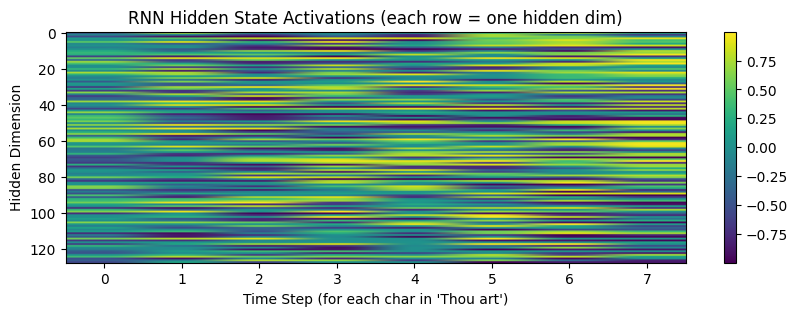

In [12]:
acts = model.get_activations("Thou art")  # shape (seq_len, hidden_size)
print("Activations shape:", acts.shape)
plt.figure(figsize=(10,3))
plt.imshow(acts.T, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("RNN Hidden State Activations (each row = one hidden dim)")
plt.xlabel("Time Step (for each char in 'Thou art')")
plt.ylabel("Hidden Dimension")
plt.show()

From the above heatmap, you can see how some hidden dimensions are more active (bright) or less active (dark) at each time step. That shows what the RNN is focusing on, reminiscent of [Karpathy’s blog post approach](https://karpathy.github.io/2015/05/21/rnn-effectiveness/).

## Conclusion

- We loaded `tiny_shakespeare`, built a small character-level LSTM in PyTorch.
- We trained for multiple epochs, showing sample text at epochs 10, 20, 30.
- We displayed next-token probability distribution for a chosen context.
- We plotted the RNN hidden state activation map to see which neurons activate.

Following [Karpathy’s blog post](https://karpathy.github.io/2015/05/21/rnn-effectiveness/), even a small RNN can learn to generate Shakespeare-like text with enough training epochs and the right hyperparameters. This approach demonstrates how each additional epoch yields more coherent text.